# **Costs prediction of a Marketing Campaign (Data Cleaning & Feature Selection- Part II)**
### A Data Science approach to predict the best candidates to be targeted for a marketing campaign

### **About the project**

This article is the 2nd out of 3 of a Machine Learning - binary classification - project which goal is to train the best machine learning model that should be able to predict the optimal number of candidates to be targeted on a Marketing Campaign, to reduce to the minimum costs and to maximize efficiency.

In order to determine the costs for the campaign to be successful, the marketing team has reached to a conclusion:

- For each customer identified as a good candidate and therefore defined as a target of the campaign but doesn't subscribe the term deposit, the bank had a cost of 500 EUR.
- For each customer who was identified as a bad candidate and therfore excluded from the target of the campaign but was actually a good candidate and would subscribe the product, the bank had a cost of 2000 EUR.

**The metric used for evaluation is the total costs since the objective is to determine the minimum costs of the marketing campaign.**

In this article, the focus is on the second section only, the Cleaning & Feature Selection.

---

## Set-up

To get (download) the data, click or copy and past this URL in a browser: https://bit.ly/31a0EAL (monitorized link)

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import pingouin as pg

import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr

from IPython.display import Image
from category_encoders import BinaryEncoder
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42

/Users/GGG/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Loading the datset
df = pd.read_csv('bank_marketing_campaign.csv')

In [3]:
# Briefly visualization of the dataset (display the first five rows by default)
df.head()

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Converting the target from binary/categoric into binary/numeric
df['target'] = df.apply(lambda row: 1 if row["y"] == "yes" else 0, axis=1)
df.drop(["y"],axis=1,inplace=True)

In [5]:
# Renaming some columns for better typing and calling variables
df.rename(columns={"emp.var.rate":"emp_var_rate",
                   "cons.price.idx":"cons_price_idx",
                   "cons.conf.idx":"cons_conf_idx",
                   "nr.employed":"nr_employed"}
          ,inplace=True)

### Setting-up numeric (df_num) and categoric (df_cat) dataframes

In [6]:
# Create numeric (df_num) and categoric (df_cat) dataframes
df_num = df.copy().select_dtypes(include=["float64","int64"])
df_cat = df.copy().select_dtypes(exclude=["float64","int64"])

In [7]:
# Create indexes
cat_features = list(df.select_dtypes('object').columns)
int_features = list(df.select_dtypes('int64').columns)
float_features = list(df.select_dtypes('float64').columns)
num_features = int_features+float_features

In the [first post](https://bit.ly/3lDzknU), we have conducted the **Exploratory Data Analysis** that has allowed us to look further and beyond the initial dataset. 

EDA can be a very time-consuming task and rarely is a one-time-walk-through but although we may find ourselves going back to early sections changing and trying a few different approaches quite often, the detailed analysis usually pays and gives us a ton of information about the data and the variables' behavior.

### Basic info of the dataset

In [8]:
# Printing number of observations and variables, including the target
print(f"Number of clients:  {df.shape[0]}") # Number of observations
print(f"Number of variables:   {df.shape[1]} incl. target") # Number of variables or attributes

Number of clients:  41188
Number of variables:   16 incl. target



[0] Number of clients that haven't subscribed the term deposit: ... 36548
[1] Number of clients that have subscribed the term deposit: ....... 4640



,clients,%
0,36548,88.73
1,4640,11.27


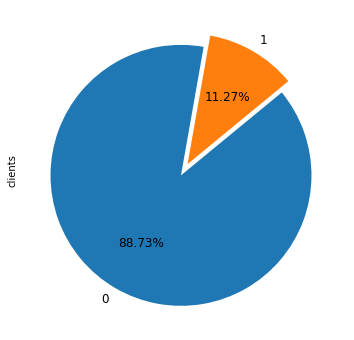

In [9]:
# How many clients have subscribed the term deposit and how many didn't?
absolut = df.target.value_counts().to_frame().rename(columns={"target":"clients"})
percent = (df.target.value_counts(normalize=True)*100).to_frame().rename(columns={"target":"%"})
df_bal = pd.concat([absolut,percent],axis=1).round(decimals=2)
print("")
print(f"[0] Number of clients that haven't subscribed the term deposit: ... {df.target.value_counts()[0]}")
print(f"[1] Number of clients that have subscribed the term deposit: ....... {df.target.value_counts()[1]}")
print("")
display(df_bal)
absolut.plot(kind='pie', subplots=True, autopct='%1.2f%%', 
             explode= (0.05, 0.05), startangle=80, 
             legend=False, fontsize=12, figsize=(14,6));

### The dataset is highly unbalanced.
From the above information we can clearly state that the dataset is absolutely unbalanced with the 0:'no' aproximately 8 times higher than 1:'yes'.

In [10]:
df.shape

(41188, 16)

## Let's step into the first section and take a brief overview.

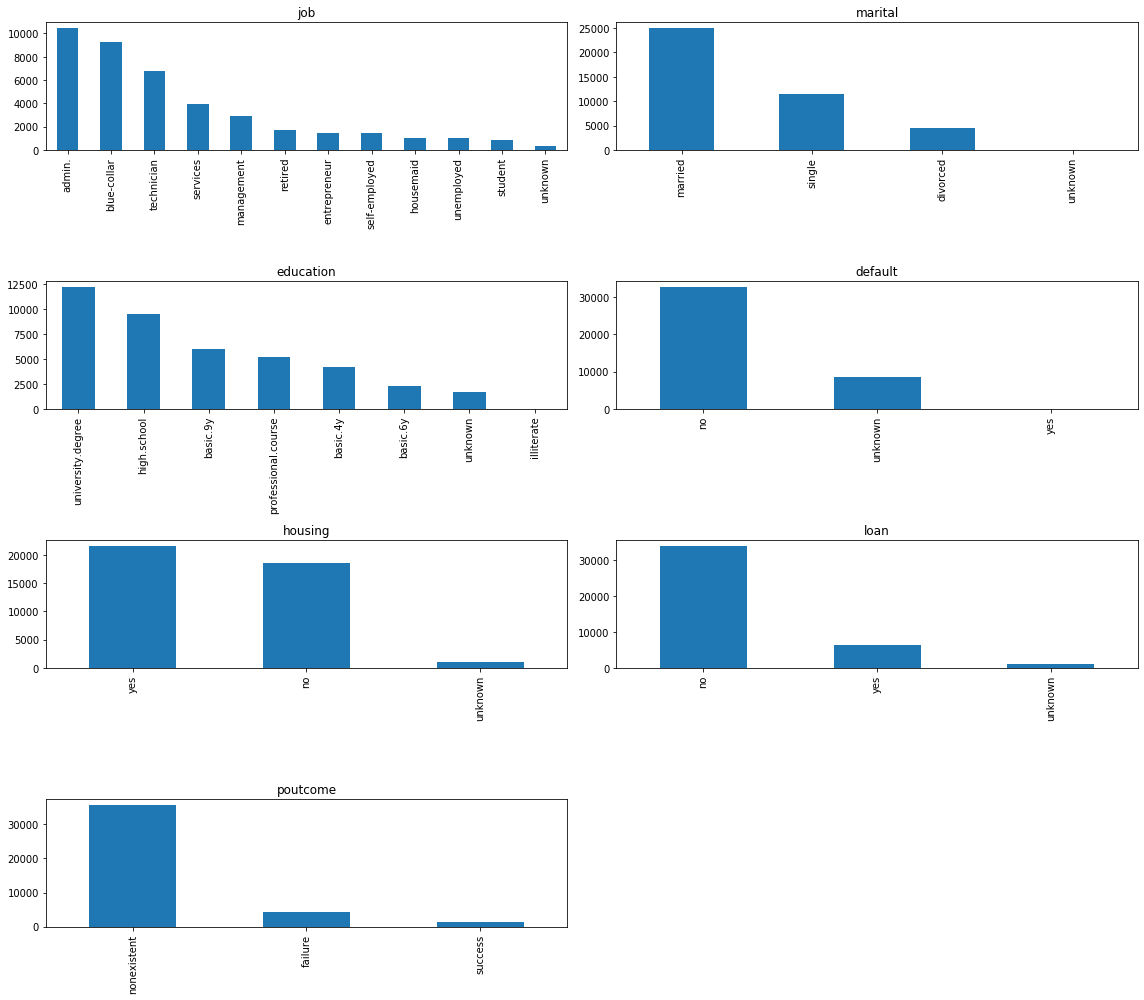

In [11]:
# What are the most common categories?

n = len(cat_features)
i=1
plt.figure(figsize=(16,14))

for feature in df[cat_features]:
    plt.subplot(round(n/2),round(n/3), i)
    df[feature].value_counts().plot.bar()
    plt.xticks(rotation=90)
    plt.title(feature)
    i+=1

plt.tight_layout();

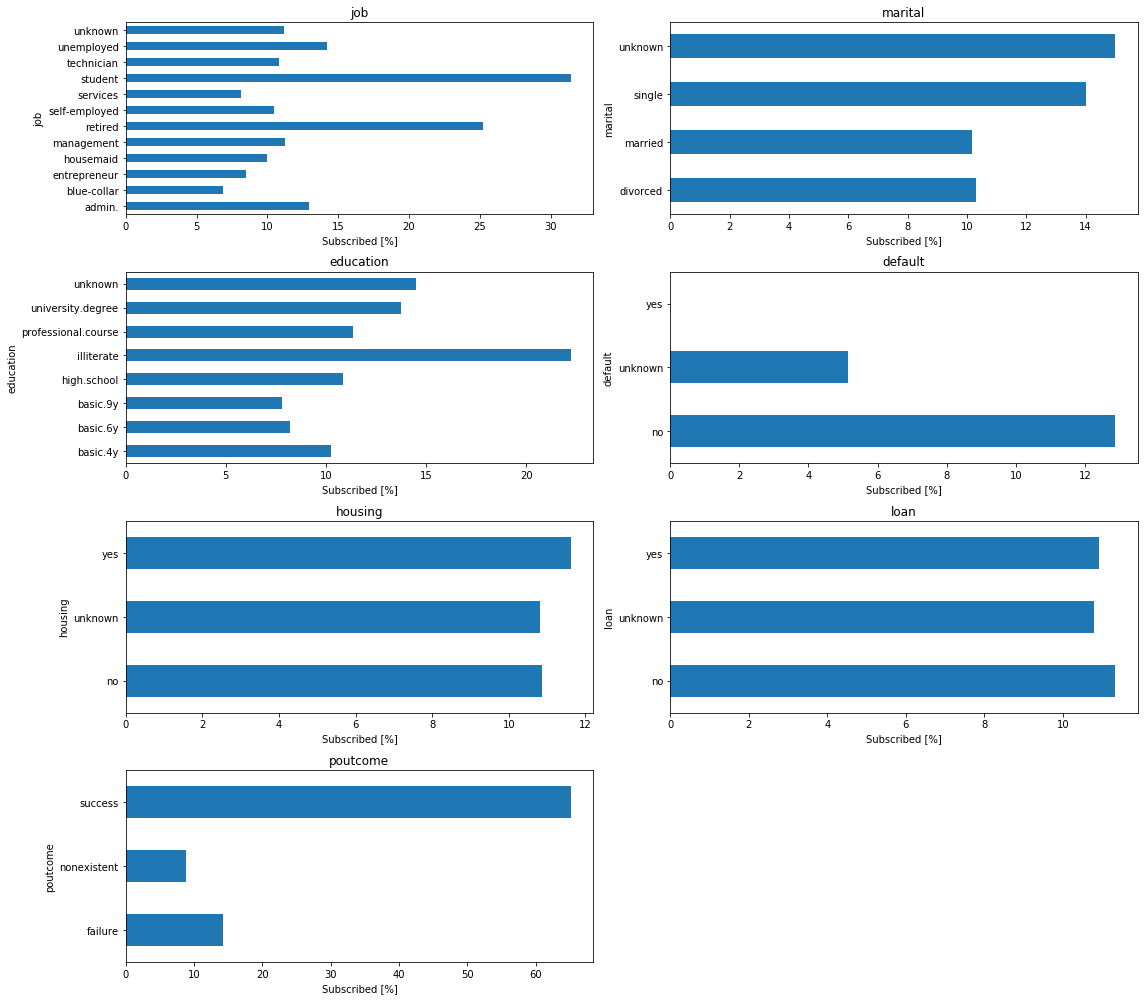

In [12]:
# How these categories influence the target variable?

n = len(cat_features)
i=1
plt.figure(figsize=(16,14))

for feature in df[cat_features]:
    plt.subplot(round(n/2),round(n/3), i)
    df.groupby([feature])['target'].mean().multiply(100).plot.barh()
    plt.xlabel('Subscribed [%]')
    plt.title(feature)
    i+=1

plt.tight_layout();

In [13]:
for col in cat_features:
    display(pd.DataFrame(df[col].value_counts()))

,job
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060
unemployed,1014


,marital
married,24928
single,11568
divorced,4612
unknown,80


,education
university.degree,12168
high.school,9515
basic.9y,6045
professional.course,5243
basic.4y,4176
basic.6y,2292
unknown,1731
illiterate,18


,default
no,32588
unknown,8597
yes,3


,housing
yes,21576
no,18622
unknown,990


,loan
no,33950
yes,6248
unknown,990


,poutcome
nonexistent,35563
failure,4252
success,1373


- You can get familiarized with the EDA section of this project by clicking [here](https://bit.ly/3lDzknU).
- You can also find the entire code of this project [here](https://bit.ly/3hmI3YS).
- The 'bank_marketing_campaign.csv' dataset can be downloaded [here](https://bit.ly/31a0EAL).

---

# **Correlations**

## **Numeric variables** (df_num)

In the context of the **dimensionality reduction**, the analysis of the correlation between features and the target variable proves to be a fundamental step in bi-variate data analysis because it helps us to compute the importance of the features. 

### Let's begin by remembering the concepts of Correlation Coefficient both Pearson and Spearman.

By definition, the **Pearson Correlation Coefficient**, commonly referred as **Pearson's r**, is a statistical measure - and a feature selection process - that describes how much two random variables are linearly correlated, how strong their statistical relationship is, in which direction it occurs, whether casual or not in bivariate data.

The values range from -1.0 and 1.0 where the first one shows the total negative linear correlation while the second one shows the total positive linear correlation. The value of 0.0 reveals there is no linear relationship.

Another important inference to be aware of is that The Pearson Correlation can only evaluate the linearity between continuous variables, meaning that the change in one variable implies a proportional change in the other, at a constant rate - otherwise it's a non-linear relationship. The use of this parametric test is only recommended when the variables are normally distributed.

One of the outputs is the **p-value for the correlation**, roughly showing the probability of an uncorrelated system creating a correlation value of some magnitude. Low p-values (usually ≤0.05) tell us that the correlation is, most probably, significant. In concrete, the p-value will reveal the feature's predictive power.

In [14]:
# Subdivision of target
ynum = df_num.target
Xnum = df_num.drop(["target"], axis= "columns")

In [15]:
# The numeric most correlated with the target (Pearson)
pearson = df_num.corr()
corr_target = pearson.target
display(corr_target.sort_values(ascending=False))
print("")
print("Ordered by rank in absolute values")
display(corr_target.abs().sort_values(ascending=False))

target            1.000000
previous          0.230181
cons_conf_idx     0.054878
age               0.030399
cons_price_idx   -0.136211
emp_var_rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr_employed      -0.354678
Name: target, dtype: float64


Ordered by rank in absolute values


target            1.000000
nr_employed       0.354678
pdays             0.324914
euribor3m         0.307771
emp_var_rate      0.298334
previous          0.230181
cons_price_idx    0.136211
cons_conf_idx     0.054878
age               0.030399
Name: target, dtype: float64

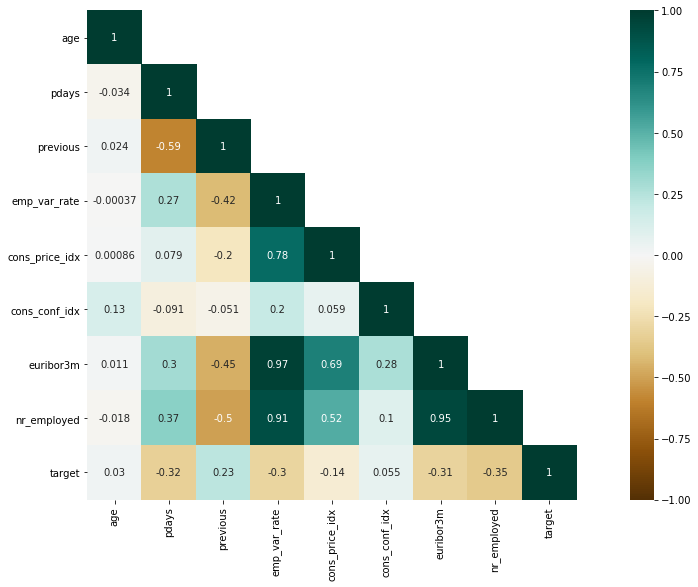

In [16]:
# Heatmap visualization: Pearson
mask = np.triu(df_num.corr(method="pearson"), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(df_num.corr(method="pearson"), annot=True, 
            vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

'Nr_employed' is the most correlated with the target followed by 'pdays', 'euribor3m', and 'emp_avr_rate' and at the same time, the strength of their relationships with the target is low. 

The table below leads us to conclude that all features have predictive power.

In [17]:
# Identifying variables with predictive power (Pearson Correlation p-value)
pd.DataFrame(
    [scipy.stats.pearsonr(Xnum[col], ynum) for col in Xnum.columns],
    columns=["Pearson Corr.", "p-value"],
    index=Xnum.columns,
).round(2)

,Pearson Corr.,p-value
age,0.03,0.0
pdays,-0.32,0.0
previous,0.23,0.0
emp_var_rate,-0.30,0.0
cons_price_idx,-0.14,0.0
cons_conf_idx,0.05,0.0
euribor3m,-0.31,0.0
nr_employed,-0.35,0.0


All variables have predictive power.
##### **Strategy:** No transformation.

---

On the other hand, the **Spearman Correlation Coefficient**, or **Spearman's r**, is a nonparametric measure of rank-order correlation that evaluates the monotonic relationship between two continuous or ordinal variables.

A monotonic relationship happens when one of the following occurs: 
- a) when the values of one variable increase so do the others' AND 
- b) when the values of one variable increase, there is a decrease in the others' BUT 
- a)+b) not at a constant rate. 

This means that all linear variable's relationships are monotonic at the same time but the inverse is not always true, simply because we can have both monotonic non-linear correlations.

In [18]:
# Numeric variables with higher monotonicity (spearman)
df_spearman = df_num.copy()
df_spearman.drop(["target"], axis=1, inplace=True)

The numeric 10 most correlated pairs, Spearman method:


,X,Y,r
0,emp_var_rate,nr_employed,0.944702
1,emp_var_rate,euribor3m,0.939915
2,euribor3m,nr_employed,0.928857
3,emp_var_rate,cons_price_idx,0.664890
4,cons_price_idx,euribor3m,0.490970
5,previous,cons_price_idx,-0.282720
6,previous,emp_var_rate,-0.435293
7,previous,nr_employed,-0.438721
8,previous,euribor3m,-0.454724
9,pdays,previous,-0.509583


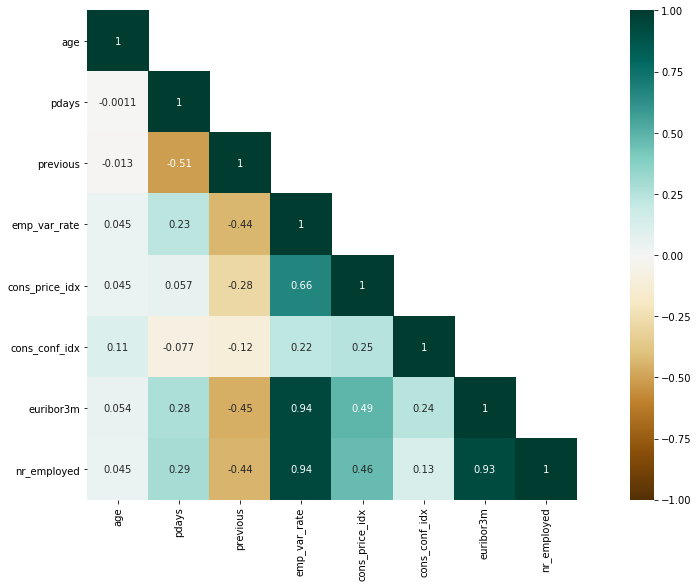

In [19]:
print("The numeric 10 most correlated pairs, Spearman method:")
spearman_rank = pg.pairwise_corr(df_spearman, method='spearman').loc[:,['X','Y','r']]
pos = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[:5,:]
neg = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[-5:,:]
con = pd.concat([pos,neg], axis=0)
display(con.reset_index(drop=True))

mask = np.triu(df_spearman.corr(method='spearman'), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(df_spearman.corr(method='spearman'), annot=True, 
            vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);


Variables 'emp_var_rate', 'nr_employed', 'euribor3m' are very redundant. 'nr_employed' is the most correlated with the target.
##### **Strategy:** Keep all variables for the time being.

---

## **Categoric variables** (df_cat_t)

The **Chi-square test for independence** is used when we want to check if there is a relationship between two categorical variables (besides, we're dealing with a binary classification problem and chi-square is a very suitable test to perform here). Firstly, I'll specify the null and alternative hypotheses to run the test.

The alternative hypothesis is always what we are trying to prove and the null is the hypothesis that we are trying to demonstrate evidence against.
- (Null hypothesis) H0: The feature and the target are independent
- (Alternative hypothesis) Ha: The feature and the target are not independent

So, for the feature to be considered relevant, we want to reject the H0 (null hypothesis) with the lowest p-value (p-value ≤0.05).

In [20]:
# Creating categoric subset in order to see correlations results
Xcat = df_cat.select_dtypes(exclude=['int64','float64']).copy()
ycat = df.target

In [21]:
# 2. Study chi² for independence:
chi2 = []
p_val = []
for feature in cat_features:
    table = pd.crosstab(df_cat[feature], ycat)
    chi2.append(round(chi2_contingency(table)[0], 2))
    p_val.append(round(chi2_contingency(table)[1], 2))

In [22]:
pd.DataFrame([chi2,p_val], columns = cat_features, index = ['chi2', 'p_value']).T

,chi2,p_value
job,961.24,0.00
marital,122.66,0.00
education,193.11,0.00
default,406.58,0.00
housing,5.68,0.06
loan,1.09,0.58
poutcome,4230.52,0.00


In [23]:
# Statistic values and meaning results for each categoric variable
for col in Xcat.columns:
    table = pd.crosstab(Xcat[col], ycat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.3f}")

target,0,1
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


p-value: 0.000



target,0,1
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


p-value: 0.000



target,0,1
education,,
basic.4y,3748,428
basic.6y,2104,188
basic.9y,5572,473
high.school,8484,1031
illiterate,14,4
professional.course,4648,595
university.degree,10498,1670
unknown,1480,251


p-value: 0.000



target,0,1
default,,
no,28391,4197
unknown,8154,443
yes,3,0


p-value: 0.000



target,0,1
housing,,
no,16596,2026
unknown,883,107
yes,19069,2507


p-value: 0.058



target,0,1
loan,,
no,30100,3850
unknown,883,107
yes,5565,683


p-value: 0.579



target,0,1
poutcome,,
failure,3647,605
nonexistent,32422,3141
success,479,894


p-value: 0.000


**Strategy: Remove variables 'housing', 'loan'** (p-value > 0.05) **and 'default'** (totaly unbalanced).

**Comments:** The 'yes' class of the **'default'** variable is meaningless and any imputation to the missing values would deeply compromise its meaning, the more effective it will be to sacrifice the variable. The **'education'** variable's classes have an order which means that it will be encoded by that same order. To the variables 'job', 'marital' and 'poutcome' will be applied a Binary Encoding and One Hot Encoding and will be evaluated concerning the best trade-off between dimensionality and information gain.

**Strategy2: Remove variables 'loan'** (p-value > 0.05) **and 'default'** (totaly unbalanced). **'housing'** it's beyond limits but i'm still going to keep it for now, I will encode it and test it again.

---
---
---

# Outliers, Missing Values, Anomalies e Transformations

## **Numeric variables** (df_num)

In [24]:
# Removing Target and making a copy
df_drop = df_num.drop(["target"], axis=1).copy()

,age,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
mean,40.02406,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
50%,38.00000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
std,10.42125,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528


Any missing values: False



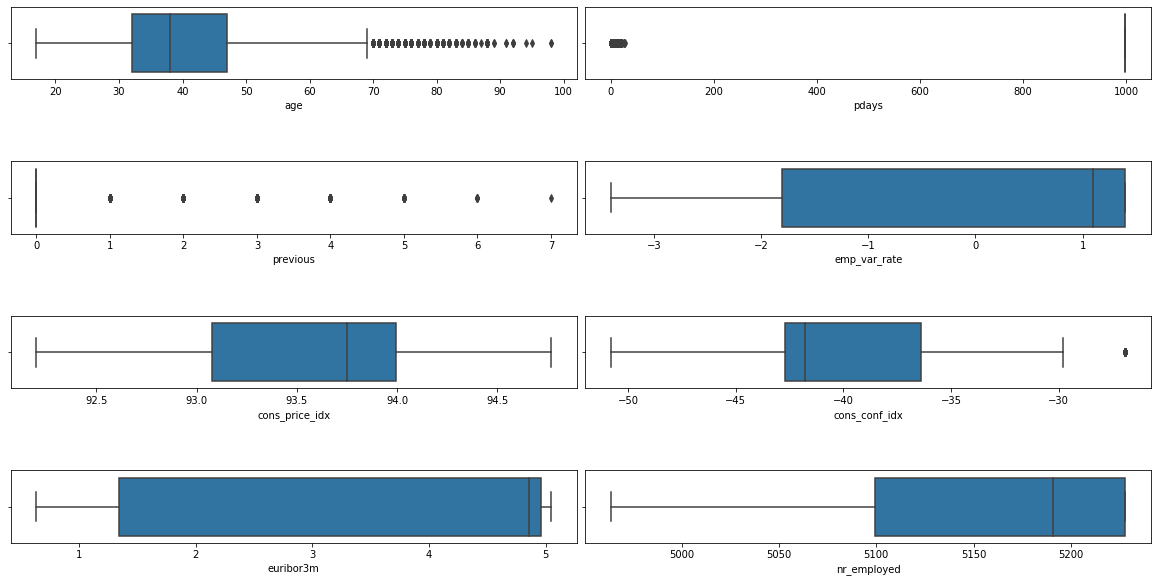

In [25]:
# Visualization of numerical data dispersion (Boxplot)
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16, 8))
index = 0
axs = axs.flatten()
for k,v in df_drop.items():
    sns.boxplot(y=k, data=df_drop, ax=axs[index], orient="h")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

display(df_drop.describe().loc[["mean","50%","std"]])
print(f"Any missing values: {df_drop.isnull().values.any()}")
print("")

The technique used identifies the values ​​that are at +1.5 IQR and -1.5 IQR of the median, a non-parametric methodology generalizable for the profile of the distributions that we find.

In [26]:
for column in df_drop.columns:
    median = df_drop[column].quantile()
    iqr_1_5 = (df_drop[column].quantile(q = 0.75) - df_drop[column].quantile(q = 0.25)) * 1.5
    outliers = df_drop[(df_drop[column]< median - iqr_1_5) | (df_drop[column] > median + iqr_1_5)][column].count()
    outliers_pct = round(outliers / df_drop[column].count() * 100, 1)
    print("'{}' = {} ({}%) outliers".format(column, outliers, outliers_pct))

'age' = 910 (2.2%) outliers
'pdays' = 1515 (3.7%) outliers
'previous' = 5625 (13.7%) outliers
'emp_var_rate' = 0 (0.0%) outliers
'cons_price_idx' = 770 (1.9%) outliers
'cons_conf_idx' = 1841 (4.5%) outliers
'euribor3m' = 0 (0.0%) outliers
'nr_employed' = 1408 (3.4%) outliers


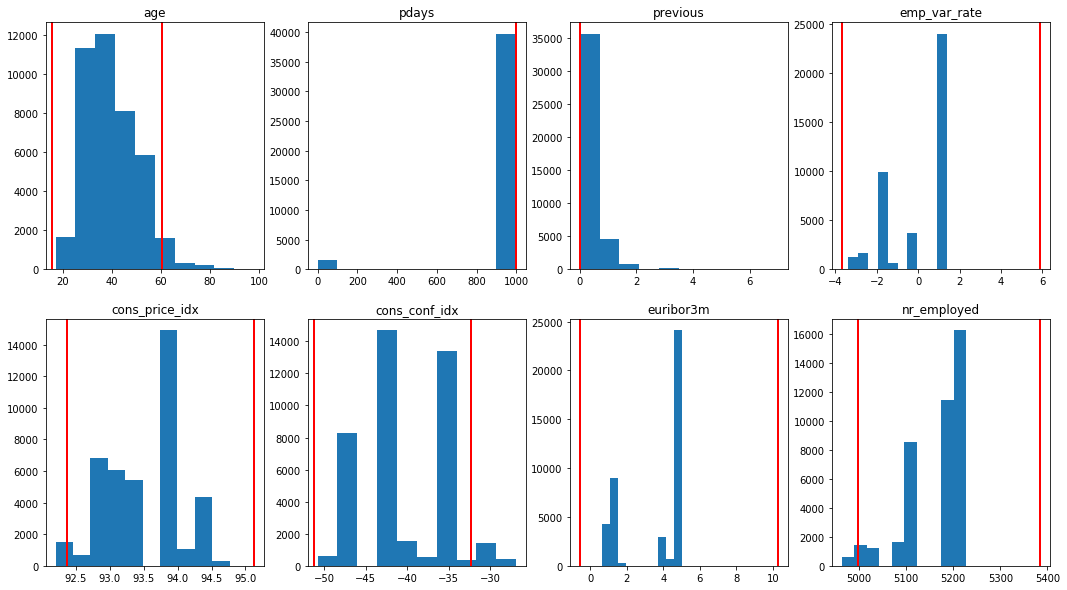

In [27]:
fig, ax  = plt.subplots(figsize = (18,10))
ax.axis("off")
v = 1
for column in df_drop.columns:
    ax1 = fig.add_subplot(2,4,v)
    plt.hist(df_drop[column])
    ax1.set_title(column)
    v+=1
    median = df_drop[column].quantile()
    iqr_1_5 = (df_drop[column].quantile(q = 0.75) - df_drop[column].quantile(q = 0.25)) * 1.5
    outliers = df_drop[(df_drop[column]< median - iqr_1_5) | (df_drop[column] > median + iqr_1_5)][column].count()
    ax1.axvline(median - iqr_1_5, color='red', linewidth=2)  
    ax1.axvline(median + iqr_1_5, color='red', linewidth=2)  

plt.show()

I realized that the method used to identify outliers selects many records, the most severe case being the previous column with almost 14% of the selected data. So, I decided to keep records for all categories mostly, as far as I can tell, because the data seems to have been measured correctly and reflects reality.

To emphasize that the model is not affected by the extension of the number of outliers, we will only guarantee that we will use a standardization technique that does not neglect to detail the distances between the central values.

From the analysis of the dispersion of the numeric data, it seems to be no outliers. The plotted data of 'age' has a normal behavior, and I assume that the extreme data points in the variable 'pdays' are 'out of range' values, as for the rest, every variable seems to have a balanced body.

Regarding missing values and other anomalies, I have analyzed the unique values and respective counts of all the numerical variables, and there seem to be no missing values.

---
---

## **Categoric veriables** (df_cat_t)

Moving on to the categoric variables, time to check if there are any missing values or other anomalies that need to be dealt with so it can be resumed by transforming these into numerical features through various techniques that will be analyzed case by case, concerning the best trade-off between dimensionality reduction and information gain.

In [28]:
# Creating a copy
df_cat_t = df_cat.copy()
df_cat.describe() # Describing the categorical dataframe 

,job,marital,education,default,housing,loan,poutcome
count,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,3
top,admin.,married,university.degree,no,yes,no,nonexistent
freq,10422,24928,12168,32588,21576,33950,35563


---

### Variable: **job**

In [29]:
print(f"Unique values: {df_cat.job.nunique()}")
print("")

# Observations by class
num_obs = df_cat.job.value_counts()
num_o = pd.DataFrame(num_obs)
num_o.rename(columns={"job":"Freq abs"}, inplace=True)
num_o_pc = (df_cat.job.value_counts(normalize=True) * 100).round(decimals=2)
num_obs_pc = pd.DataFrame(num_o_pc)
num_obs_pc.rename(columns={"job":"percent %"}, inplace=True)
n_obs = pd.concat([num_o,num_obs_pc], axis=1)
display(n_obs)

Unique values: 12



,Freq abs,percent %
admin.,10422,25.30
blue-collar,9254,22.47
technician,6743,16.37
services,3969,9.64
management,2924,7.10
retired,1720,4.18
entrepreneur,1456,3.54
self-employed,1421,3.45
housemaid,1060,2.57
unemployed,1014,2.46


In this case, 'unknown' is our missing value. The strategy here is to impute the 'unknowns' by the most frequent value, the modal value. Let's start by converting it into a np.nan and then perform the imputation.

Unique values: 11


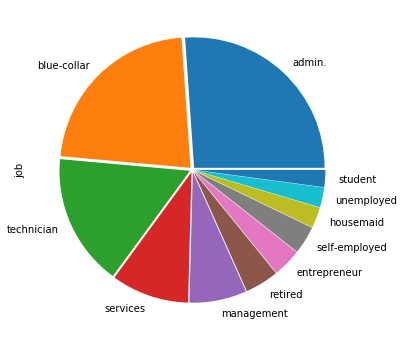

In [30]:
# Replacing 'unknown' by NaN
df_cat_t.job.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation missing values by the modal value
df_cat_t['job'] = df_cat_t.job.fillna(df_cat_t.job.value_counts().index[0])

# Confirming and visualizing of "job"
df_cat_t.job.value_counts(dropna=False).plot(kind='pie', figsize=(10,6), 
                                           explode=(0.02, 0.02, 0.02, 0.02, 
                                                    0.02, 0.02, 0.02, 0.02,
                                                    0.02, 0.02, 0.02));
print(f"Unique values: {df_cat_t.job.nunique()}")

I'll also be displaying the results of how many extra columns both One Hot Encoding and Binary Encoding would create under the encoding procedure.

In [31]:
# Encoding 'job' OHE or BIN
df_job = df_cat_t.job
job_ohe = pd.get_dummies(df_job)
binary_encoder_job = BinaryEncoder()
job_bin = binary_encoder_job.fit_transform(df_job)
print(f'''
*Results*
job OHE: {job_ohe.shape[1]} columns
job BIN: {job_bin.shape[1]} columns''')


*Results*
job OHE: 11 columns
job BIN: 5 columns


Binary Encoding to be applied here. Although there is some loss of information in comparison with OHE, it is a better trade-off in terms of dimensionality reduction.

In [32]:
# Removing 'job' and concatenation job_bin
df_cat_t.drop(["job"],axis=1,inplace=True)
df_cat_t = pd.concat([df_cat_t,job_bin],axis=1)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,marital,education,default,housing,loan,poutcome,job_0,job_1,job_2,job_3,job_4
0,married,basic.4y,no,no,no,nonexistent,0,0,0,0,1
1,married,high.school,unknown,no,no,nonexistent,0,0,0,1,0


(41188, 11)

---

### Variable: **marital**

In [33]:
print(f"Unique values: {df_cat.marital.nunique()}")
print("")

# Observations by class
marital_obs = df_cat.marital.value_counts()
marital_o = pd.DataFrame(marital_obs)
marital_o.rename(columns={"marital":"Freq abs"}, inplace=True)
marital_o_pc = (df_cat.marital.value_counts(normalize=True) * 100).round(decimals=2)
marital_obs_pc = pd.DataFrame(marital_o_pc)
marital_obs_pc.rename(columns={"marital":"percent %"}, inplace=True)
marital_obs = pd.concat([marital_o,marital_obs_pc], axis=1)
display(marital_obs)

Unique values: 4



,Freq abs,percent %
married,24928,60.52
single,11568,28.09
divorced,4612,11.20
unknown,80,0.19


‘Unknown’ is interpreted as a missing value. It is the same situation as with the ‘job’ variable. The strategy is to impute the missing values by the most frequent value.

Unique values: 3



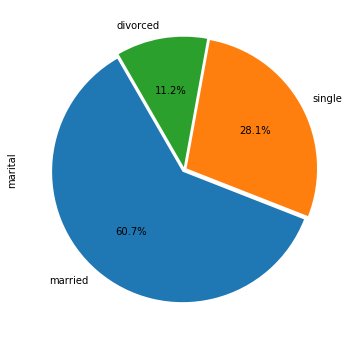

In [34]:
# Replacing 'unknown' by NaN
df_cat_t.marital.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
df_cat_t['marital'] = df_cat_t.marital.fillna(df_cat_t.marital.value_counts().index[0])

# Graph "pie"
df_cat_t['marital'].value_counts(dropna=False).plot(kind='pie', figsize=(10,6),
                                              explode = (0.02, 0.02, 0.02),
                                              autopct='%1.1f%%',
                                              startangle=120);
print(f"Unique values: {df_cat_t.marital.nunique()}")
print("")

Again, displaying the results of how many extra columns both One Hot Encoding and Binary Encoding would create with the encoding procedure.

In [35]:
# marital
df_marital = df_cat_t.marital
marital_ohe = pd.get_dummies(df_marital)
binary_encoder_marital = BinaryEncoder()
marital_bin = binary_encoder_marital.fit_transform(df_marital)
print(f'''
*Results*
marital OHE: {marital_ohe.shape[1]} columns
marital BIN: {marital_bin.shape[1]} columns''')


*Results*
marital OHE: 3 columns
marital BIN: 3 columns


One Hot Encoding to be applied here as it preserves more information in comparison with Binary Encoding.

In [36]:
df_cat_t.drop(["marital"],axis=1,inplace=True)
df_cat_t = pd.concat([df_cat_t,marital_ohe],axis=1)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,education,default,housing,loan,poutcome,job_0,job_1,job_2,job_3,job_4,divorced,married,single
0,basic.4y,no,no,no,nonexistent,0,0,0,0,1,0,1,0
1,high.school,unknown,no,no,nonexistent,0,0,0,1,0,0,1,0


(41188, 13)

---

### Variable: **education**

In [37]:
print(f"Unique values: {df_cat.education.nunique()}")
print("")

# Observations by class
edu_obs = df_cat.education.value_counts()
edu_o = pd.DataFrame(edu_obs)
edu_o.rename(columns={"education":"Freq abs"}, inplace=True)
edu_o_pc = (df_cat.education.value_counts(normalize=True) * 100).round(decimals=2)
edu_obs_pc = pd.DataFrame(edu_o_pc)
edu_obs_pc.rename(columns={"education":"percent %"}, inplace=True)
edu_obs = pd.concat([edu_o,edu_obs_pc], axis=1)
display(edu_obs)

Unique values: 8



,Freq abs,percent %
university.degree,12168,29.54
high.school,9515,23.10
basic.9y,6045,14.68
professional.course,5243,12.73
basic.4y,4176,10.14
basic.6y,2292,5.56
unknown,1731,4.20
illiterate,18,0.04


We're looking at the same case where ‘unknown’ is interpreted as missing values. The strategy adopted is to impute by the most frequent value.

Unique values: 7



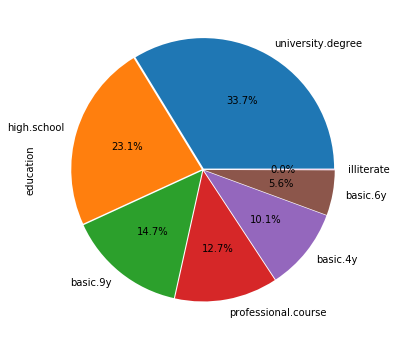

In [38]:
# Replacing 'unknown' by NaN
df_cat_t.education.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
df_cat_t['education'] = df_cat_t.education.fillna(df_cat_t.education.value_counts().index[0])

# Graph "pie"
df_cat_t['education'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(10,6), 
                                                explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=0);
print(f"Unique values: {df_cat_t.education.nunique()}")
print("")

In [39]:
df_cat_t.education.value_counts()

university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64

'Education'' has 8 classes that obey a specific order meaning it will be encoded considering that same rank. The ascending order is: 'Illiterate', ' basic.4y', 'nasic.6y', 'basic.9y', 'high.school', 'professional.course', and 'university.degree'.

For this purpose, I will apply a map function. Data mapping is used for replacing a specific set of values in a Series by another set of values, that may be derived from a function, a dict or a Series.

In [40]:
df_cat_t["education"] = df_cat_t.education.map({"university.degree":7, 
                                                "professional.course":6,
                                                "high.school":5,"basic.9y":4,
                                                "basic.6y":3, "basic.4y":2,
                                                "illiterate":1 })
display(df_cat_t.education.value_counts())
display(df_cat_t.head(2))
display(df_cat_t.shape)

7    13899
5     9515
4     6045
6     5243
2     4176
3     2292
1       18
Name: education, dtype: int64

,education,default,housing,loan,poutcome,job_0,job_1,job_2,job_3,job_4,divorced,married,single
0,2,no,no,no,nonexistent,0,0,0,0,1,0,1,0
1,5,unknown,no,no,nonexistent,0,0,0,1,0,0,1,0


(41188, 13)

---

### Variable: **default**

Unique values: 3



,Freq abs,percent %
no,32588,79.12
unknown,8597,20.87
yes,3,0.01


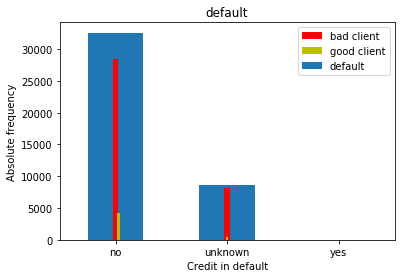

In [41]:
print(f"Unique values: {df.default.nunique()}")
print("")

# Visualizing graph "bar"
df['default'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));

# Number of observations by class
default_obs = df.default.value_counts()
default_o = pd.DataFrame(default_obs)
default_o.rename(columns={"default":"Freq abs"}, inplace=True)
default_o_pc = (df.default.value_counts(normalize=True) * 100).round(decimals=2)
default_obs_pc = pd.DataFrame(default_o_pc)
default_obs_pc.rename(columns={"default":"percent %"}, inplace=True)
default_obs = pd.concat([default_o,default_obs_pc], axis=1)
display(default_obs)


# Graph 'default' vs. 'target'
default_0 = df[df.target == 0].iloc[:,4:5]
default_1 = df[df.target == 1].iloc[:,4:5]

a = np.array(default_0)
b = np.array(default_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('default', fontsize=12)
plt.xlabel('Credit in default')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

In this case, 'unknown' values are interpreted as missing values. The 'yes' class is meaningless and any imputation of the 'unknown' values could deeply compromise all the results. Therefore, it's better to remove this variable.

In [42]:
df_cat_t.drop(["default"], axis=1, inplace=True)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,education,housing,loan,poutcome,job_0,job_1,job_2,job_3,job_4,divorced,married,single
0,2,no,no,nonexistent,0,0,0,0,1,0,1,0
1,5,no,no,nonexistent,0,0,0,1,0,0,1,0


(41188, 12)

---

### Variable: **housing**

In [43]:
print(f"Unique values: {df_cat.housing.nunique()}")
print("")

# Observations by class
hous_obs = df_cat.housing.value_counts()
hous_o = pd.DataFrame(hous_obs)
hous_o.rename(columns={"housing":"Freq abs"}, inplace=True)
hous_o_pc = (df_cat.housing.value_counts(normalize=True) * 100).round(decimals=2)
hous_obs_pc = pd.DataFrame(hous_o_pc)
hous_obs_pc.rename(columns={"housing":"percent %"}, inplace=True)
hous_obs = pd.concat([hous_o,hous_obs_pc], axis=1)
display(hous_obs)

Unique values: 3



,Freq abs,percent %
yes,21576,52.38
no,18622,45.21
unknown,990,2.40


In this case, 'unknown' are interpreted as missing values.
##### **Strategy:** Replacing by the most frequent value.

Unique values: 2



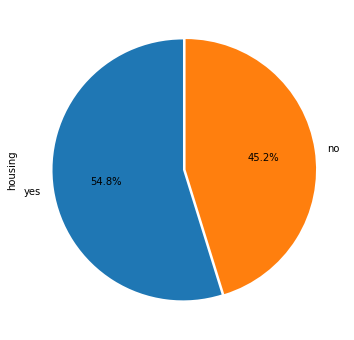

In [44]:
# Replacing 'unknown' by NaN
df_cat_t.housing.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
df_cat_t['housing'] = df_cat_t.housing.fillna(df_cat_t.housing.value_counts().index[0])

# Visualizing "pie" graph
df_cat_t['housing'].value_counts(dropna=False).plot(kind='pie', 
                                              explode = (0.01, 0.01), 
                                              figsize=(10,6), 
                                              autopct='%1.1f%%',
                                              startangle=90);
print(f"Unique values: {df_cat_t.housing.nunique()}")
print("")

For the Chi-square test, this variable has revealed has with little statistic importance.
##### **Strategy:** Remove variable.

In [45]:
df_cat_t.drop(["housing"], axis=1, inplace=True)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,education,loan,poutcome,job_0,job_1,job_2,job_3,job_4,divorced,married,single
0,2,no,nonexistent,0,0,0,0,1,0,1,0
1,5,no,nonexistent,0,0,0,1,0,0,1,0


(41188, 11)

---

### Variable: **loan**

In [46]:
print(f"Unique values: {df_cat.loan.nunique()}")
print("")

# Observations by class
loan_obs = df_cat.loan.value_counts()
loan_o = pd.DataFrame(loan_obs)
loan_o.rename(columns={"loan":"Freq abs"}, inplace=True)
loan_o_pc = (df_cat.loan.value_counts(normalize=True) * 100).round(decimals=2)
loan_obs_pc = pd.DataFrame(loan_o_pc)
loan_obs_pc.rename(columns={"loan":"percent %"}, inplace=True)
loan_obs = pd.concat([loan_o,loan_obs_pc], axis=1)
display(loan_obs)

Unique values: 3



,Freq abs,percent %
no,33950,82.43
yes,6248,15.17
unknown,990,2.40


In this case, 'unknown' are interpreted as missing values.
##### **Strategy:** Replacing by the most frequent value.

Unique values: 2



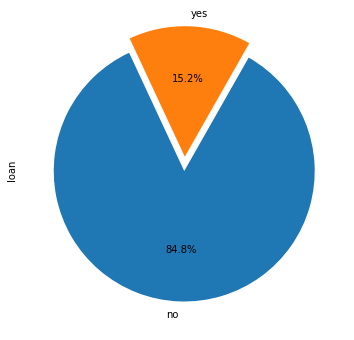

In [47]:
# Replacing 'unknown' by NaN
df_cat_t.loan.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
df_cat_t['loan'] = df_cat_t.loan.fillna(df_cat_t.loan.value_counts().index[0])

# Visualizing "pie" graph
df_cat_t['loan'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(10,6), 
                                                explode = (0.01, 0.1),
                                                autopct='%1.1f%%',
                                                startangle=115);
print(f"Unique values: {df_cat_t.loan.nunique()}")
print("")

For the Chi-square test, this variable has revealed has with little statistic importance.
##### **Strategy:** Remove variable.

In [48]:
df_cat_t.drop(["loan"], axis=1, inplace=True)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,education,poutcome,job_0,job_1,job_2,job_3,job_4,divorced,married,single
0,2,nonexistent,0,0,0,0,1,0,1,0
1,5,nonexistent,0,0,0,1,0,0,1,0


(41188, 10)

---

### Variável: **poutcome**

Unique values: 3



,Freq abs,percent %
nonexistent,35563,86.34
failure,4252,10.32
success,1373,3.33


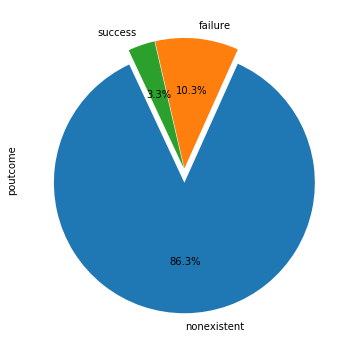

In [49]:
print(f"Unique values: {df_cat.poutcome.nunique()}")
print("")

# Graph "pie"
df['poutcome'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(10,6), 
                                                explode = (0.1, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=115);

# Number of observation by class
pout_obs = df.poutcome.value_counts()
pout_o = pd.DataFrame(pout_obs)
pout_o.rename(columns={"poutcome":"Freq abs"}, inplace=True)
pout_o_pc = (df.poutcome.value_counts(normalize=True) * 100).round(decimals=2)
pout_obs_pc = pd.DataFrame(pout_o_pc)
pout_obs_pc.rename(columns={"poutcome":"percent %"}, inplace=True)
pout_obs = pd.concat([pout_o,pout_obs_pc], axis=1)
pout_obs

In this case, 'nonexistent' are interpreted as relevant values. The strategy to follow is to do no transformation to this variable.

In [50]:
# Encoding 'poutcome' OHE
df_poutcome = df_cat_t.poutcome
poutcome_ohe = pd.get_dummies(df_poutcome)
binary_encoder_poutcome = BinaryEncoder()
poutcome_bin = binary_encoder_poutcome.fit_transform(df_poutcome)
print(f'''
*Results*
poutcome OHE: {poutcome_ohe.shape[1]} columns
poutcome BIN: {poutcome_bin.shape[1]} columns''')


*Results*
poutcome OHE: 3 columns
poutcome BIN: 3 columns


In [51]:
# Remove 'poutcome' and concatenation poutcome_ohe
df_cat_t.drop(["poutcome"],axis=1,inplace=True)
df_cat_t = pd.concat([df_cat_t,poutcome_ohe],axis=1)
display(df_cat_t.head(2))
display(df_cat_t.shape)

,education,job_0,job_1,job_2,job_3,job_4,divorced,married,single,failure,nonexistent,success
0,2,0,0,0,0,1,0,1,0,0,1,0
1,5,0,0,0,1,0,0,1,0,0,1,0


(41188, 12)

In [52]:
df_cat_t.dtypes

education      int64
job_0          int64
job_1          int64
job_2          int64
job_3          int64
job_4          int64
divorced       uint8
married        uint8
single         uint8
failure        uint8
nonexistent    uint8
success        uint8
dtype: object

In [53]:
# Analysis of the transformed dataset
display(df_cat_t.dtypes)
print("")
print(f"df_cat (original): ........ {df_cat.shape}")
print(f"df_cat_t (transformed): ... {df_cat_t.shape}")

education      int64
job_0          int64
job_1          int64
job_2          int64
job_3          int64
job_4          int64
divorced       uint8
married        uint8
single         uint8
failure        uint8
nonexistent    uint8
success        uint8
dtype: object


df_cat (original): ........ (41188, 7)
df_cat_t (transformed): ... (41188, 12)


In [54]:
# Concatenation of both numeric and categorical datasets
df_numcat = pd.concat([df_cat_t,df_num], axis=1)

# Removing any NaNs or anomalies just to make sure
df_numcat.dropna(how="any", axis=0)

,education,job_0,job_1,job_2,job_3,job_4,divorced,married,single,failure,...,success,age,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
0,2,0,0,0,0,1,0,1,0,0,...,0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,5,0,0,0,1,0,0,1,0,0,...,0,57,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,5,0,0,0,1,0,0,1,0,0,...,0,37,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,3,0,0,0,1,1,0,1,0,0,...,0,40,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,5,0,0,0,1,0,0,1,0,0,...,0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6,0,0,1,1,0,0,1,0,0,...,0,73,999,0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,6,0,0,1,0,0,0,1,0,0,...,0,46,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,7,0,0,1,1,0,0,1,0,0,...,0,56,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,6,0,0,1,0,1,0,1,0,0,...,0,44,999,0,-1.1,94.767,-50.8,1.028,4963.6,1


At this stage, after dealing with all the missing values and imputations and transforming all categorical features into numerical ones, let us check for the correlations of the features, identifying and selecting the variables with no predictive power.

In [55]:
# Subdivision of the target
y_numcat = df_numcat.target
X_numcat = df_numcat.drop(["target"], axis= "columns")

In [56]:
# Identifying all variables with great predictive power (Pearson Correlation p-value)
dataframe = pd.DataFrame(
    [scipy.stats.pearsonr(X_numcat[col], y_numcat) for col in X_numcat.columns],
    columns=["Pearson Corr.", "p-value"],
    index=X_numcat.columns,
).round(2).sort_values(by="p-value", ascending=False)

display(dataframe)

,Pearson Corr.,p-value
divorced,-0.01,0.03
education,0.06,0.00
success,0.32,0.00
euribor3m,-0.31,0.00
cons_conf_idx,0.05,0.00
cons_price_idx,-0.14,0.00
emp_var_rate,-0.30,0.00
previous,0.23,0.00
pdays,-0.32,0.00
age,0.03,0.00


In [57]:
# Identifying columns in which p-value > 0.05
column = []
for item in dataframe.index:
    if dataframe['p-value'][item] >= 0.05:
        column.append(item)

In [58]:
# Removing statistically non significant columns
df_numcat.drop(column, axis=1, inplace=True)

In [59]:
df_numcat.shape

(41188, 21)

In [60]:
df_numcat

,education,job_0,job_1,job_2,job_3,job_4,divorced,married,single,failure,...,success,age,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
0,2,0,0,0,0,1,0,1,0,0,...,0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,5,0,0,0,1,0,0,1,0,0,...,0,57,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,5,0,0,0,1,0,0,1,0,0,...,0,37,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,3,0,0,0,1,1,0,1,0,0,...,0,40,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,5,0,0,0,1,0,0,1,0,0,...,0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6,0,0,1,1,0,0,1,0,0,...,0,73,999,0,-1.1,94.767,-50.8,1.028,4963.6,1
41184,6,0,0,1,0,0,0,1,0,0,...,0,46,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,7,0,0,1,1,0,0,1,0,0,...,0,56,999,0,-1.1,94.767,-50.8,1.028,4963.6,0
41186,6,0,0,1,0,1,0,1,0,0,...,0,44,999,0,-1.1,94.767,-50.8,1.028,4963.6,1


Et voilà. We are all set to go for the third and last part, definitely the most exciting phase of our project, the modeling part. See you there.

---

**Author:** Gonçalo Guimarães Gomes. Portuguese Data Analyst and Digital Brand Marketer. Postgraduate in Data Science and in Digital Marketing. 5 yrs Degree and Executive Master in Marketing Management.

### **Contacts**

Feel free to contact me:

- [Linkedin](http://bit.ly/2ybRqYT)
- [Twitter](https://bit.ly/3gAwMTP)
- [Medium](https://bit.ly/3gDC5Sp)
- [GitHub](https://bit.ly/3hHvuHR)
- [Kaggle](https://bit.ly/31Co038)
- [Email](mailto:goncaloggomes@gmail.com)